# DC resistivity forward modelling to determine detectability of fault offset: A case study of two sites in the Fraser Canyon: Phase 1
_Raul Benjamin Mendoza_

In this notebook, I aim to use _discretize_ and _SimPEG_ to replicate the results I attained from inverting field data using EarthImager:
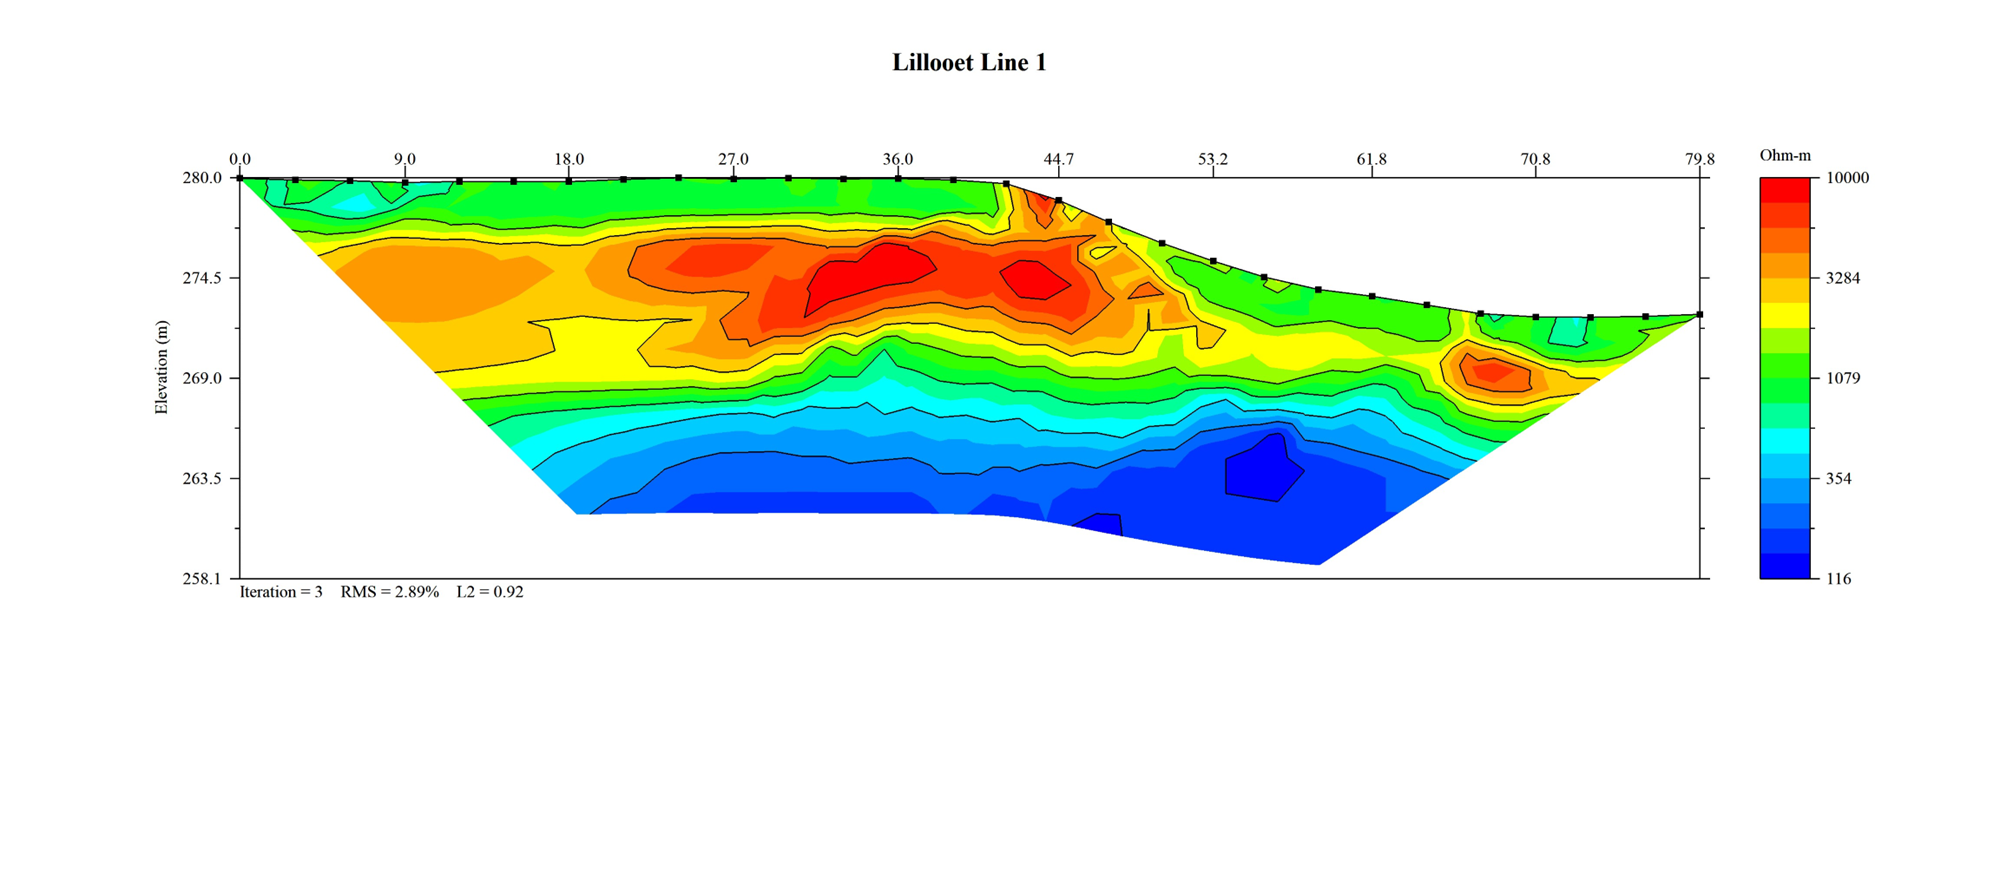

For now, this notebook loosely follows the SimPEG 2.5D DC Resistivity forward modelling and inversion tutorial notebooks (https://simpeg.xyz/user-tutorials/fwd-dcr-2d & https://simpeg.xyz/user-tutorials/inv-dcr-2d). 

## Import packages for forward modelling

In [ ]:
# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    write_dcip2d_ubc,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    generate_survey_from_abmn_locations,
    geometric_factor
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

# Functions specific to this project
from project_functions import (
    create_topography_from_terrain_file,
    plot_topography_from_dataframe,
    extract_survey_and_data_from_stg,
    plot_survey,
    create_mesh_from_survey,
    plot_mesh_and_survey,
    plot_model_on_survey_and_mesh)

mpl.rcParams.update({"font.size": 14})  # default font size

write_output = False  # Optional

## Create Survey object

### Define topography 
Use create_topography_from_terrain_file function.

In [2]:
TERRAIN_FILE_COLUMN_NAMES = ['x','z']
TERRAIN_FILE_PATH = './fieldData/Terrain_Line1_3m_Aug26_2024.trn'

topography_2d = create_topography_from_terrain_file(terrain_file_path=TERRAIN_FILE_PATH,
                                                    terrain_file_column_names=TERRAIN_FILE_COLUMN_NAMES)

In [3]:
# plot_topography_from_dataframe(topography_2d)

### Generate Survey object
Use the topography data and the raw .stg data file.

In [4]:
STG_FILEPATH = './fieldData/3m_Texas_Creek_line1_2024.stg'

In [5]:
survey, field_VI, field_Ohmm, field_error_permille, _ = extract_survey_and_data_from_stg(
    topography_2d=topography_2d,
    stg_filepath=STG_FILEPATH,
    electrode_spacing=3,
    datatype='volt'
    )

Note: If you see 'UserWarning: Ordering of ABMN locations changed when generating survey,' you may disregard it 
because the extract_survey_and_data_from_stg function sorts the data for you. To compare the survey and sorted data 
with the unsorted data, this function also returns the sorting_indices array that was used to sort the raw data. 



c:\GitSpaces\eosc-556b-project\project_functions.py:160: UserWarning: Ordering of ABMN locations changed when generating survey. Associated data vectors will need sorting. Set output_sorting to True for sorting indices.
  survey, sorting_indices = generate_survey_from_abmn_locations(locations_a=locations_a, locations_b=locations_b,


### Plot survey setup and check survey attributes

In [6]:
# plot_survey(survey)

# Check survey
attributes = vars(survey)
for att, value in attributes.items():
    print(f"{att}: {value}")

_source_list: [Dipole(a: [  3.01915289 279.839     ]; b: [  0.    279.927]), Dipole(a: [  6.01871657 279.798     ]; b: [  3.01915289 279.839     ]), Dipole(a: [  9.01509641 279.704     ]; b: [  6.01871657 279.798     ]), Dipole(a: [ 11.97617521 279.76      ]; b: [  9.01509641 279.704     ]), Dipole(a: [ 14.95739276 279.755     ]; b: [ 11.97617521 279.76      ]), Dipole(a: [ 17.96085236 279.75      ]; b: [ 14.95739276 279.755     ]), Dipole(a: [ 20.95405883 279.866     ]; b: [ 17.96085236 279.75      ]), Dipole(a: [ 23.95254155 279.964     ]; b: [ 20.95405883 279.866     ]), Dipole(a: [ 26.95847823 279.897     ]; b: [ 23.95254155 279.964     ]), Dipole(a: [ 29.95579679 279.946     ]; b: [ 26.95847823 279.897     ]), Dipole(a: [ 32.96030751 279.9       ]; b: [ 29.95579679 279.946     ]), Dipole(a: [ 35.94713383 279.923     ]; b: [ 32.96030751 279.9       ]), Dipole(a: [ 38.96200126 279.843     ]; b: [ 35.94713383 279.923     ]), Dipole(a: [ 41.84664293 279.635     ]; b: [ 38.96200126 279

## Create Mesh object

In [7]:
mesh, active_cells = create_mesh_from_survey(survey=survey)

Base cell size: 0.74 m
padding_cells_by_level parameter: [16, 6, 1, 1, 1, 1, 1]
# of cells: 3524
# of nodes: 3729
Max cell volume: 560.7424000000007 sq.m.


## Modify Survey object to fit the mesh

<Axes: title={'center': 'Mesh and survey setup'}, xlabel='x [m]', ylabel='elevation [m]'>

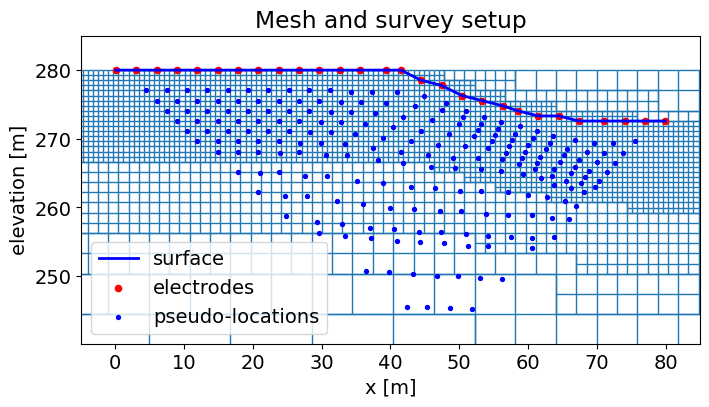

In [8]:
# Drape electrodes on topography to ensure none of them are "floating" in the air
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")
# Geometric factor is needed to convert from measured normalized voltages to apparent resistivities
survey.set_geometric_factor(space_type='half-space')

# Plot the modified survey on the mesh
plot_mesh_and_survey(mesh=mesh, survey=survey)

## Create the hypothetical "true" model

### Define material resistivities
From Palacky (1988):

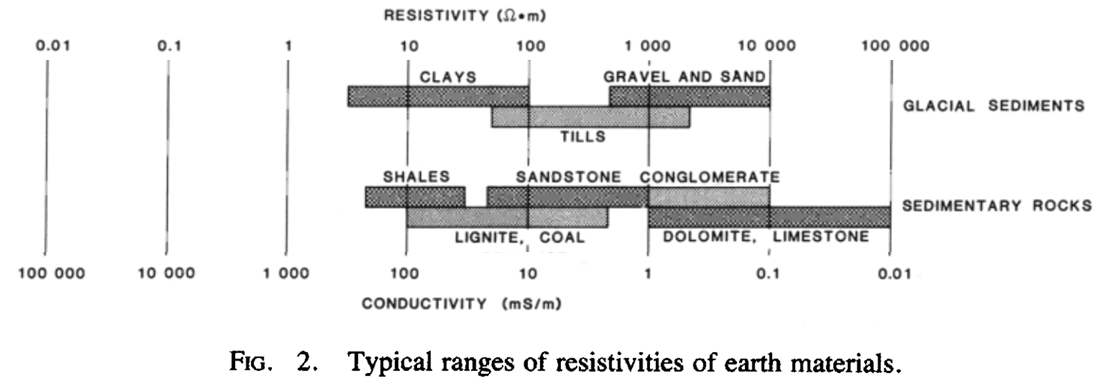

and from Lowrie (2007):

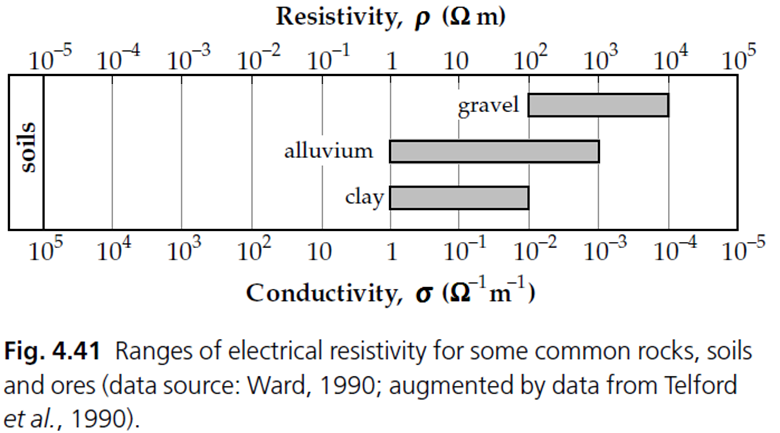

In [9]:
# Define resistivity values of different materials
air_logresistivity = np.log(1e+8)
mud_logresistivity = np.log(1e+2)
sand_logresistivity = np.log(1e+3)
gravel_logresistivity = np.log(1e+4)
air_resistivity = 1e+8

### Assign materials to different blocks
Attempt to replicate this:

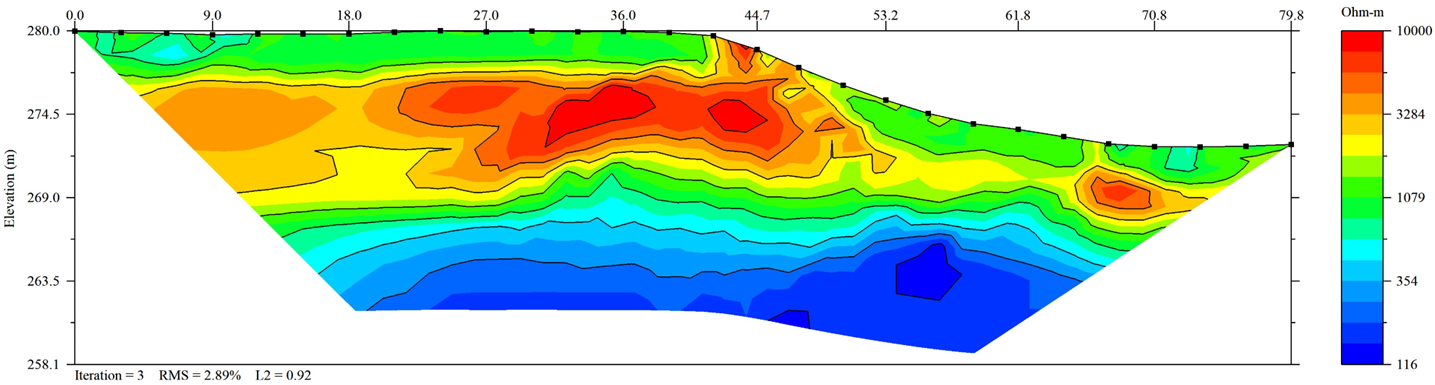

In [10]:
# number of active cells
number_of_active_cells = np.sum(active_cells)

# SIMPLE MODEL
# Define background resistivity model as sand.
logresistivity_model = sand_logresistivity *np.ones(number_of_active_cells)
starting_logresistivity_model = sand_logresistivity *np.ones(number_of_active_cells)

# Add units of different resistivities
ind_gravel = model_builder.get_indices_block(np.r_[-40,271],np.r_[48,276.5],mesh.cell_centers[active_cells, :])
logresistivity_model[ind_gravel] = gravel_logresistivity

ind_gravel2 = model_builder.get_indices_block(np.r_[65,267],np.r_[120,271],mesh.cell_centers[active_cells, :])
logresistivity_model[ind_gravel2] = gravel_logresistivity

ind_mud = model_builder.get_indices_block(np.r_[-40,258],np.r_[120,266],mesh.cell_centers[active_cells,:])
logresistivity_model[ind_mud] = mud_logresistivity

# FAULTED MODEL (fault at x = 42, right side moves down by 2m)
logresistivity_model_faulted = sand_logresistivity *np.ones(number_of_active_cells)

ind_gravel1_faulted_left = model_builder.get_indices_block(np.r_[-40,271],np.r_[42,276.5],mesh.cell_centers[active_cells, :])
ind_gravel1_faulted_right = model_builder.get_indices_block(np.r_[42,269],np.r_[48,274.5],mesh.cell_centers[active_cells, :])
ind_gravel2_faulted = model_builder.get_indices_block(np.r_[65,265],np.r_[120,269],mesh.cell_centers[active_cells, :])
ind_mud_faulted_left = model_builder.get_indices_block(np.r_[-40,258],np.r_[42,266],mesh.cell_centers[active_cells,:])
ind_mud_faulted_right = model_builder.get_indices_block(np.r_[42,256],np.r_[120,264],mesh.cell_centers[active_cells,:])

logresistivity_model_faulted[ind_gravel1_faulted_left] = gravel_logresistivity
logresistivity_model_faulted[ind_gravel1_faulted_right] = gravel_logresistivity
logresistivity_model_faulted[ind_gravel2] = gravel_logresistivity
logresistivity_model_faulted[ind_mud_faulted_left] = mud_logresistivity
logresistivity_model_faulted[ind_mud_faulted_right] = mud_logresistivity

### Create Map objects
One for the inversion (i.e., resistivity_map) where the inactive cells are given the res. value of air to keep the inversion stable.

One for figures (i.e., plotting_map) where the inactive cells are given nan values, so that they simply aren't plotted.

In [ ]:
# Resistivity map. Model parameters are log-resistivities for all active cells.
# Assign value of air to inactive cells
logresistivity_map = maps.InjectActiveCells(mesh=mesh,
                                            active_cells=active_cells,
                                            value_inactive=air_logresistivity
                                            ) * maps.ExpMap(nP=number_of_active_cells)

# Generate a mapping to ignore inactive cells in plot. Whenever you want to plot the model, you need to multiply
# the resistivity values by this plotting map
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

### Plot the hypothetical "true" model

In [ ]:
# def plot_model_on_survey_and_mesh(mesh, logresistivity_model, plotting_map,
#                                   survey=None, colormap_name='jet', title='Log-resistivity model',
#                                   full=False, buffer=5.0, vertical_exaggeration=1, ax=None):
#     '''
#     INPUTS
#     mesh: SimPEG Mesh object upon which to plot the model.
#     logresistivity_model: Array of model parameters. The values are assumed to be in log-resistivity units.
#     plotting_map: SimPEG Map object, used to hide the inactive cells of the mesh.
#     survey: SimPEG Survey object. Optional; used to plot the surface topography, electrode positions, and pseudo-locations.
#     colormap_name: String. The colormap to use for the log resistivity values. Default is jet.
#     title: String. Figure title. Default is 'Log-resistivity model'.
#     full: Boolean. Set to True to plot the whole mesh. Set to False and use buffer to plot around the survey set-up.
#         Default is False.
#     buffer: Float that defines the buffer, in meters, to plot around the highest electrode, lowest pseudo-location,
#         and leftmost and rightmost electrodes. Default is 5 meters.
#     vertical_exaggeration: Float. Default is 1.0.
#     ax: Matplotlib figure Axes object.

#     RETURNS
#     '''
#     if ax is None:
#         fig, ax = plt.subplots(1,1, figsize=(9,4))
    
#     # Map log of minimum and maximum resistivities to the colormap 0 to 1 range.
#     norm = LogNorm(vmin=np.e**mud_logresistivity, vmax=np.e**gravel_logresistivity)

#     # Plot resistivity values on mesh
#     mesh.plot_image(
#         plotting_map * np.e**logresistivity_model,
#         ax=ax,
#         grid=False,
#         pcolor_opts={"norm": norm, "cmap": colormap_name}
#     )

#     # Overlay mesh
#     mesh.plot_grid(ax=ax, linewidth = 0.5, alpha=0.5, color='black')

#     # If the survey is given, overlay topography, electrodes, and pseudo-locations.
#     if survey is not None:
#         # Extract survey electrodes and pseudo-locations
#         electrode_coordinates = survey.unique_electrode_locations
#         survey_pseudo_locations = pseudo_locations(survey)

#         # Plot topography as blue line
#         ax.plot(electrode_coordinates[:,0], electrode_coordinates[:,1], color="b", linewidth=2, label='surface', zorder=2)
#         # Plot electrodes as red dots
#         ax.scatter(electrode_coordinates[:,0], electrode_coordinates[:,1], 20, "r", label='electrodes')
#         # Plot pseudo-locations as blue dots
#         ax.scatter(survey_pseudo_locations[:,0], survey_pseudo_locations[:,1], 8, "b", label='pseudo-locations')

#     # Set vertical exaggeration
#     ax.set_aspect(vertical_exaggeration, adjustable='box')

#     # Set x and y limits if full=False and a Survey object is given.
#     if full is False and survey is not None:
#         xlim_max = electrode_coordinates[:,0].max()
#         xlim_min = electrode_coordinates[:,0].min()
#         ylim_max = electrode_coordinates[:,1].max()
#         ylim_min = survey_pseudo_locations[:,1].min()
#         ax.set_xlim(xlim_min-buffer, xlim_max+buffer)
#         ax.set_ylim(ylim_min-buffer, ylim_max+buffer)

#     # Other figure elements
#     ax.grid(False)
#     ax.set_ylabel('elevation [m]')
#     ax.set_xlabel('x [m]')
#     ax.set_title('Resistivity model')
    
#     # Add colorbar
#     scalarMappable = plt.cm.ScalarMappable(cmap=colormap_name, norm=norm)
#     scalarMappable.set_array([])
#     cbar = fig.colorbar(scalarMappable, ax=ax)
#     cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

#     return ax

<Axes: title={'center': 'Resistivity model'}, xlabel='x [m]', ylabel='elevation [m]'>

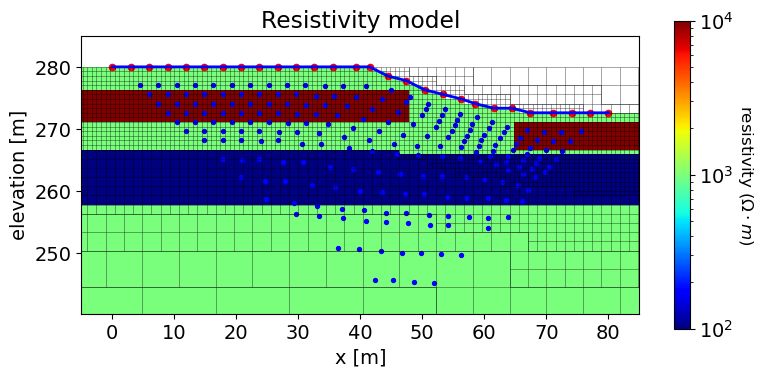

In [21]:
plot_model_on_survey_and_mesh(mesh=mesh,logresistivity_model=logresistivity_model,
                              plotting_map=plotting_map, survey=survey)

NameError: name 'xlim_min' is not defined

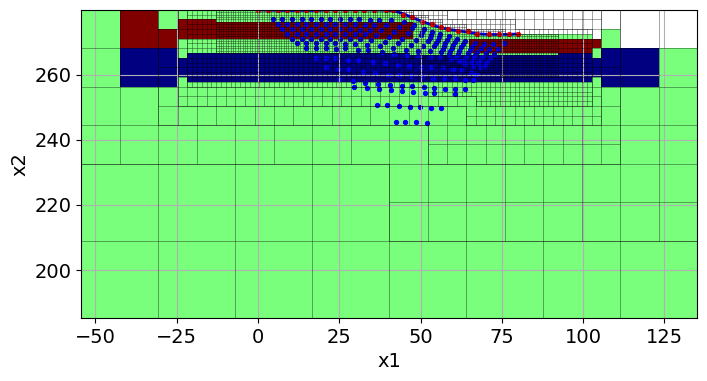

In [13]:
# Extract survey electrodes and pseudo-locations
electrode_coordinates = survey.unique_electrode_locations
survey_pseudo_locations = pseudo_locations(survey)

fig3, ax3 = plt.subplots(1,1, figsize=(9,4))

colormap_name = 'jet'

# Map log of minimum and maximum resistivities to the colormap 0 to 1 range.
norm = LogNorm(vmin=np.e**mud_logresistivity, vmax=np.e**gravel_logresistivity)

# Plot resistivity values on mesh
mesh.plot_image(
    plotting_map * np.e**logresistivity_model,
    ax=ax3,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": colormap_name}
)

# Overlay mesh, topography, electrodes, and pseudo-locations
# Plot mesh
mesh.plot_grid(ax=ax3, linewidth = 0.5, alpha=0.5, color='black')
# Plot topography z-column vs x-column
ax3.plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax3.scatter(electrode_coordinates[:,0],electrode_coordinates[:,1], 8, "r", label='electrodes')
# Plot pseudo-locations
ax3.scatter(survey_pseudo_locations[:, 0], survey_pseudo_locations[:, -1], 8, "b", label='pseudo-locations')
# Set vertical exaggeration to 1
ax3.set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax3.set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax3.set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax3.set_title("Resistivity Model")
ax3.set_xlabel("x (m)")
ax3.set_ylabel("z (m)")
ax3.grid(False)

# Add colorbar
scalarMappable = plt.cm.ScalarMappable(cmap=colormap_name, norm=norm)
scalarMappable.set_array([])
cbar = fig3.colorbar(scalarMappable, ax=ax3)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

## Plot "faulted" model

In [ ]:
fig3, ax3 = plt.subplots(1,1, figsize=(9,4))

colormap_name = 'jet'

# Map log of minimum and maximum resistivities to the colormap 0 to 1 range.
norm = LogNorm(vmin=np.e**mud_logresistivity, vmax=np.e**gravel_logresistivity)

# Plot resistivity values on mesh
mesh.plot_image(
    plotting_map * np.e**logresistivity_model_faulted,
    ax=ax3,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": colormap_name}
)

# Overlay mesh, topography, electrodes, and pseudo-locations
# Plot mesh
mesh.plot_grid(ax=ax3, linewidth = 0.5, alpha=0.5, color='black')
# Plot topography z-column vs x-column
ax3.plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax3.scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax3.scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Plot pseudo-locations
ax3.scatter(survey_pseudo_locations[:, 0], survey_pseudo_locations[:, -1], 8, "b", label='pseudo-locations')
# Set vertical exaggeration to 1
ax3.set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax3.set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax3.set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax3.set_title("Faulted Resistivity Model")
ax3.set_xlabel("x (m)")
ax3.set_ylabel("z (m)")
ax3.grid(False)

# Add colorbar
scalarMappable = plt.cm.ScalarMappable(cmap=colormap_name, norm=norm)
scalarMappable.set_array([])
cbar = fig3.colorbar(scalarMappable, ax=ax3)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

## Create Simulation object from the Mesh, the Survey, and the resistivity Map

In [ ]:
# First define the DC simulation given the survey setup, the mesh, and the active parts of the mesh
simulation_res = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=logresistivity_map
)

## Predict the DC resistivity data from the Simulation and the hypothetical model

In [ ]:
# Simulate the data from the model
dpred_res = simulation_res.dpred(logresistivity_model)
# The dpred is always in measured normalized voltages (voltage divided by current, volts/amps, V/A; i.e., resistance).

# Check the size of dpred_res
dpred_res.size

In [ ]:
dpred_res_faulted = simulation_res.dpred(logresistivity_model_faulted)

### Plot the predicted data in a pseudosection

In [ ]:
# Get apparent resistivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(survey,dpred_res)

In [ ]:
potentials = field_apparent_resistivities_sorted * geometric_factor(survey, 'half-space')

In [ ]:
fig4, ax4 = plt.subplots(2,1, figsize=(8,8))

# TOP PLOT
plot_pseudosection(
    data=survey,
    dobs= dpred_res,
    plot_type="scatter",
    ax=ax4[0],
    scale="log",
    cbar_label="Resistance [V/A]",
    scatter_opts={"cmap": colormap_name}
)

# Overlay topography, electrodes, and pseudo-locations
ax4[0].grid()
# Plot topography z-column vs x-column
ax4[0].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax4[0].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax4[0].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax4[0].set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax4[0].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax4[0].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax4[0].set_xlabel("")
ax4[0].set_ylabel("Pseudo-elevation [m]")
ax4[0].set_title("Normalized Voltages")

# BOTTOM PLOT
plot_pseudosection(
    survey,
    dobs= apparent_resistivities,
    plot_type="contourf",
    ax=ax4[1],
    scale="log",
    cbar_label=r"$\Omega \cdot m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": colormap_name},
)
ax4[1].set_title("Apparent Resistivity")
# Overlay topography, electrodes, and pseudo-locations
ax4[1].grid()
# Plot topography z-column vs x-column
ax4[1].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax4[1].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax4[1].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax4[1].set_aspect('equal', adjustable='box')
# Plot pseudo-locations
ax4[1].scatter(survey_pseudo_locations[:, 0], survey_pseudo_locations[:, -1], marker=".", s=4, color='grey', label='pseudo-locations')

# Configure x- and y-axes
ax4[1].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax4[1].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax4[1].set_xlabel("x [m]")
ax4[1].set_ylabel("Pseudo-elevation [m]")

fig4.tight_layout()

## Create Data object

### Add noise to predicted data and call it the observed data, dobs.

In [ ]:
# Add 5% Gaussian noise to each datum for the simulated data
# Create random number generator (RNG)
rng = np.random.default_rng(seed=225)
std = 0.05 * np.abs(dpred_res)
dc_noise = rng.normal(scale=std, size=len(dpred_res))
dobs = dpred_res + dc_noise

# Create data object
data_noisy = data.Data(survey, dobs=dobs, standard_deviation=std)

In [ ]:
# Add 5% Gaussian noise to each datum for the simulated data
# Create random number generator (RNG)
rng2 = np.random.default_rng(seed=225)
std_faulted = 0.05 * np.abs(dpred_res_faulted)
dc_noise_faulted = rng2.normal(scale=std, size=len(dpred_res_faulted))
dobs_faulted = dpred_res_faulted + dc_noise

# Create data object
data_faulted_noisy = data.Data(survey, dobs=dobs_faulted, standard_deviation=std_faulted)

### Export Data object

In [ ]:
filename = "./outputs/Data_objects/data_noisy.obs"
write_dcip2d_ubc(filename,data_noisy,data_type='volt',file_type='dobs')

## Field Data object
!!! Check if error should be as a ratio of 1, or as a data-dimension value.

In [ ]:
# For field data
# Assume uncertainties are 10% of the data value
field_standard_deviation = np.maximum((field_error_estimates_sorted), np.ones_like(field_error_estimates_sorted)/2500) * np.abs(field_normalized_voltages_sorted)
field_dobs = field_normalized_voltages_sorted
field_data = data.Data(survey, dobs=field_dobs, standard_deviation=field_standard_deviation)

attributes = vars(field_data)
for name, value in attributes.items():
    print(f"{name}: {value}")

# DC Resistivity 2.5D least-squares inversion 

## Import packages

In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

from simpeg.utils import model_builder
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc


mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

## Starting/Reference Model and Mapping on Tree Mesh

Here, we would create starting and/or reference models for the DC inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the starting model is the natural log of 0.01 S/m.

In [ ]:
# Define starting model
# nC = int(active_cells.sum())
# starting_resistivity_model = sand_resistivity * np.ones(n_active)

## Define the DC Inverse Problem
The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [ ]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=field_data, simulation=simulation_res)

# Define the regularization (model objective function)
referencemod = starting_logresistivity_model
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    reference_model=referencemod
)

reg.reference_model_in_smooth = True  # Reference model in smoothness term

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define DC Inversion Directives

Here we define any directives that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.

In [ ]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=2)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=True)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

## Create and run the DC Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.

In [ ]:
# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
startingmodel= starting_logresistivity_model
recovered_resistivity_model = dc_inversion.run(startingmodel)

### Plot recovered model

In [ ]:
referencemodel = logresistivity_model
norm = LogNorm(vmin=1e+2, vmax=1e+4)
fig5, ax5 = plt.subplots(2,1, figsize=(9,9))

# TOP PLOT
mesh.plot_image(
    plotting_map * np.e**referencemodel,
    ax=ax5[0],
    grid=False,
    pcolor_opts={"norm": norm, "cmap": colormap_name},
)
# Overlay mesh, topography, electrodes, and pseudo-locations
# Plot mesh
mesh.plot_grid(ax=ax5[0], linewidth = 0.5, alpha=0.5, color='black')
ax5[0].grid(False)
# Plot topography z-column vs x-column
ax5[0].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax5[0].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax5[0].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax5[0].set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax5[0].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax5[0].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax5[0].set_xlabel("")
ax5[0].set_ylabel("z [m]")
ax5[0].set_title("Hypothetical True Resistivity Model")

# Add colorbar
scalarMappable = plt.cm.ScalarMappable(cmap=colormap_name, norm=norm)
scalarMappable.set_array([])
cbar_top = fig5.colorbar(scalarMappable, ax=ax5[0])
cbar_top.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

# BOTTOM PLOT
mesh.plot_image(
    plotting_map * np.e**recovered_resistivity_model,
    ax=ax5[1],
    grid=False,
    pcolor_opts={"norm": norm, "cmap": colormap_name},
)
# Overlay mesh, topography, electrodes, and pseudo-locations
# Plot mesh
mesh.plot_grid(ax=ax5[1], linewidth = 0.5, alpha=0.5, color='black')
ax5[1].grid(False)
# Plot topography z-column vs x-column
ax5[1].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax5[1].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax5[1].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax5[1].set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax5[1].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
# ax5[1].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax5[1].set_ylim(258, ylim_max+buffer_in_meters)
ax5[1].set_xlabel("x [m]")
ax5[1].set_ylabel("z [m]")
ax5[1].set_title(f"Recovered Resistivity Model \n survey data type: {datatype}, mesh base width: {dh}")

# Add colorbar
cbar_bottom = fig5.colorbar(scalarMappable, ax=ax5[1])
cbar_bottom.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.tight_layout()

In [ ]:
dpred = inv_prob.dpred
dobs = data_faulted_noisy.dobs
std = data_faulted_noisy.standard_deviation


In [ ]:
residual = dpred - dobs
relative_misfits = (residual/np.abs(dobs)) # Probably better to look at
# misfits = ((1/std)* residual)**2
relative_misfits.size

In [ ]:
rms = np.sqrt(np.sum(relative_misfits**2)/relative_misfits.size)*100
rms

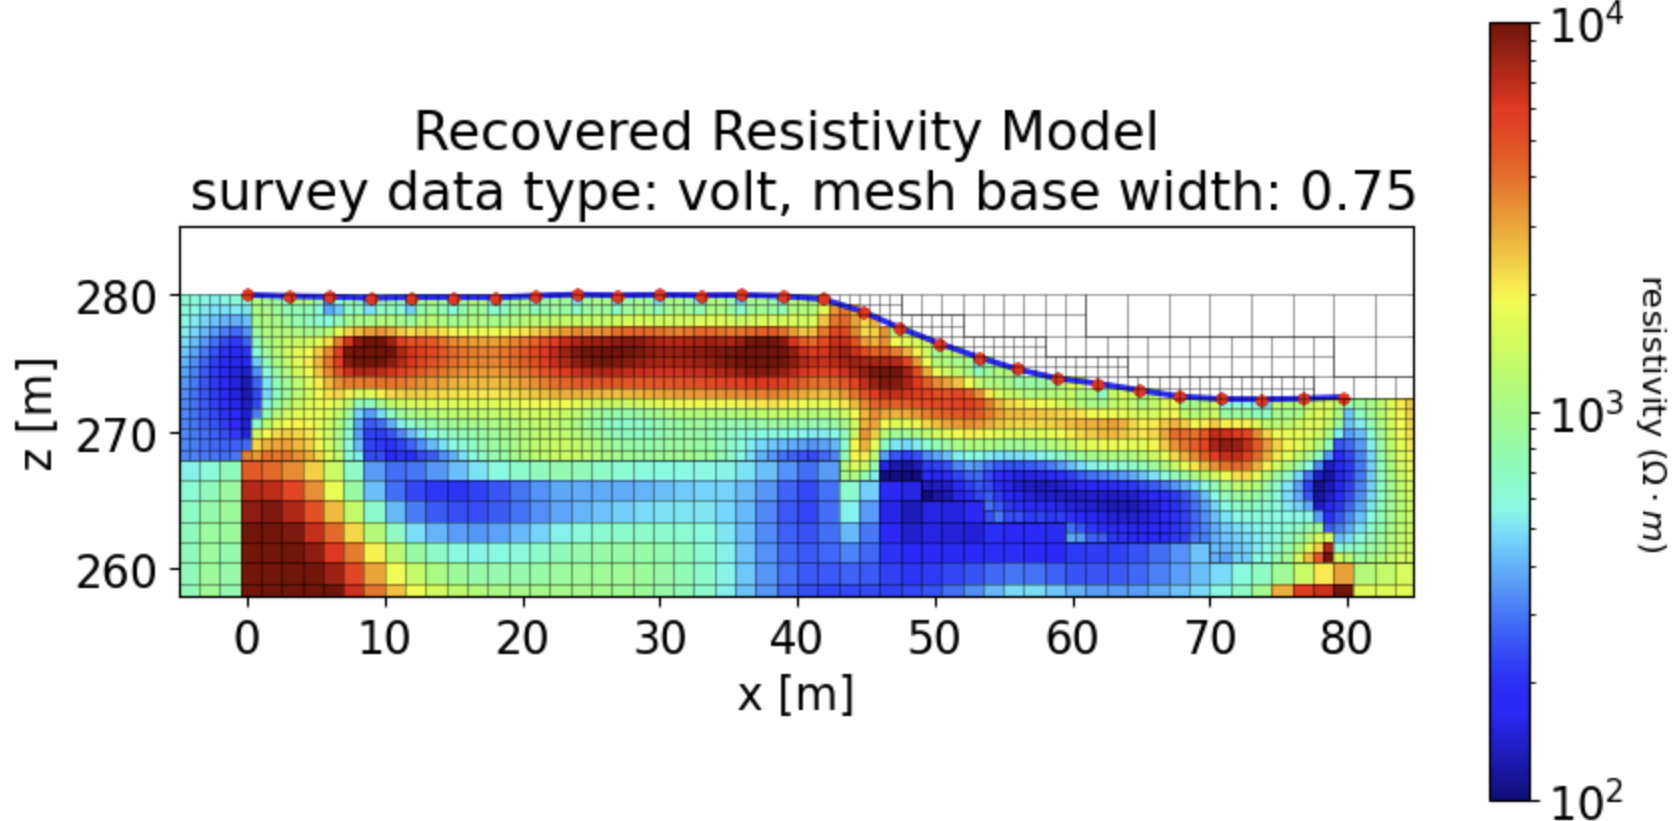
Field data:

With noise

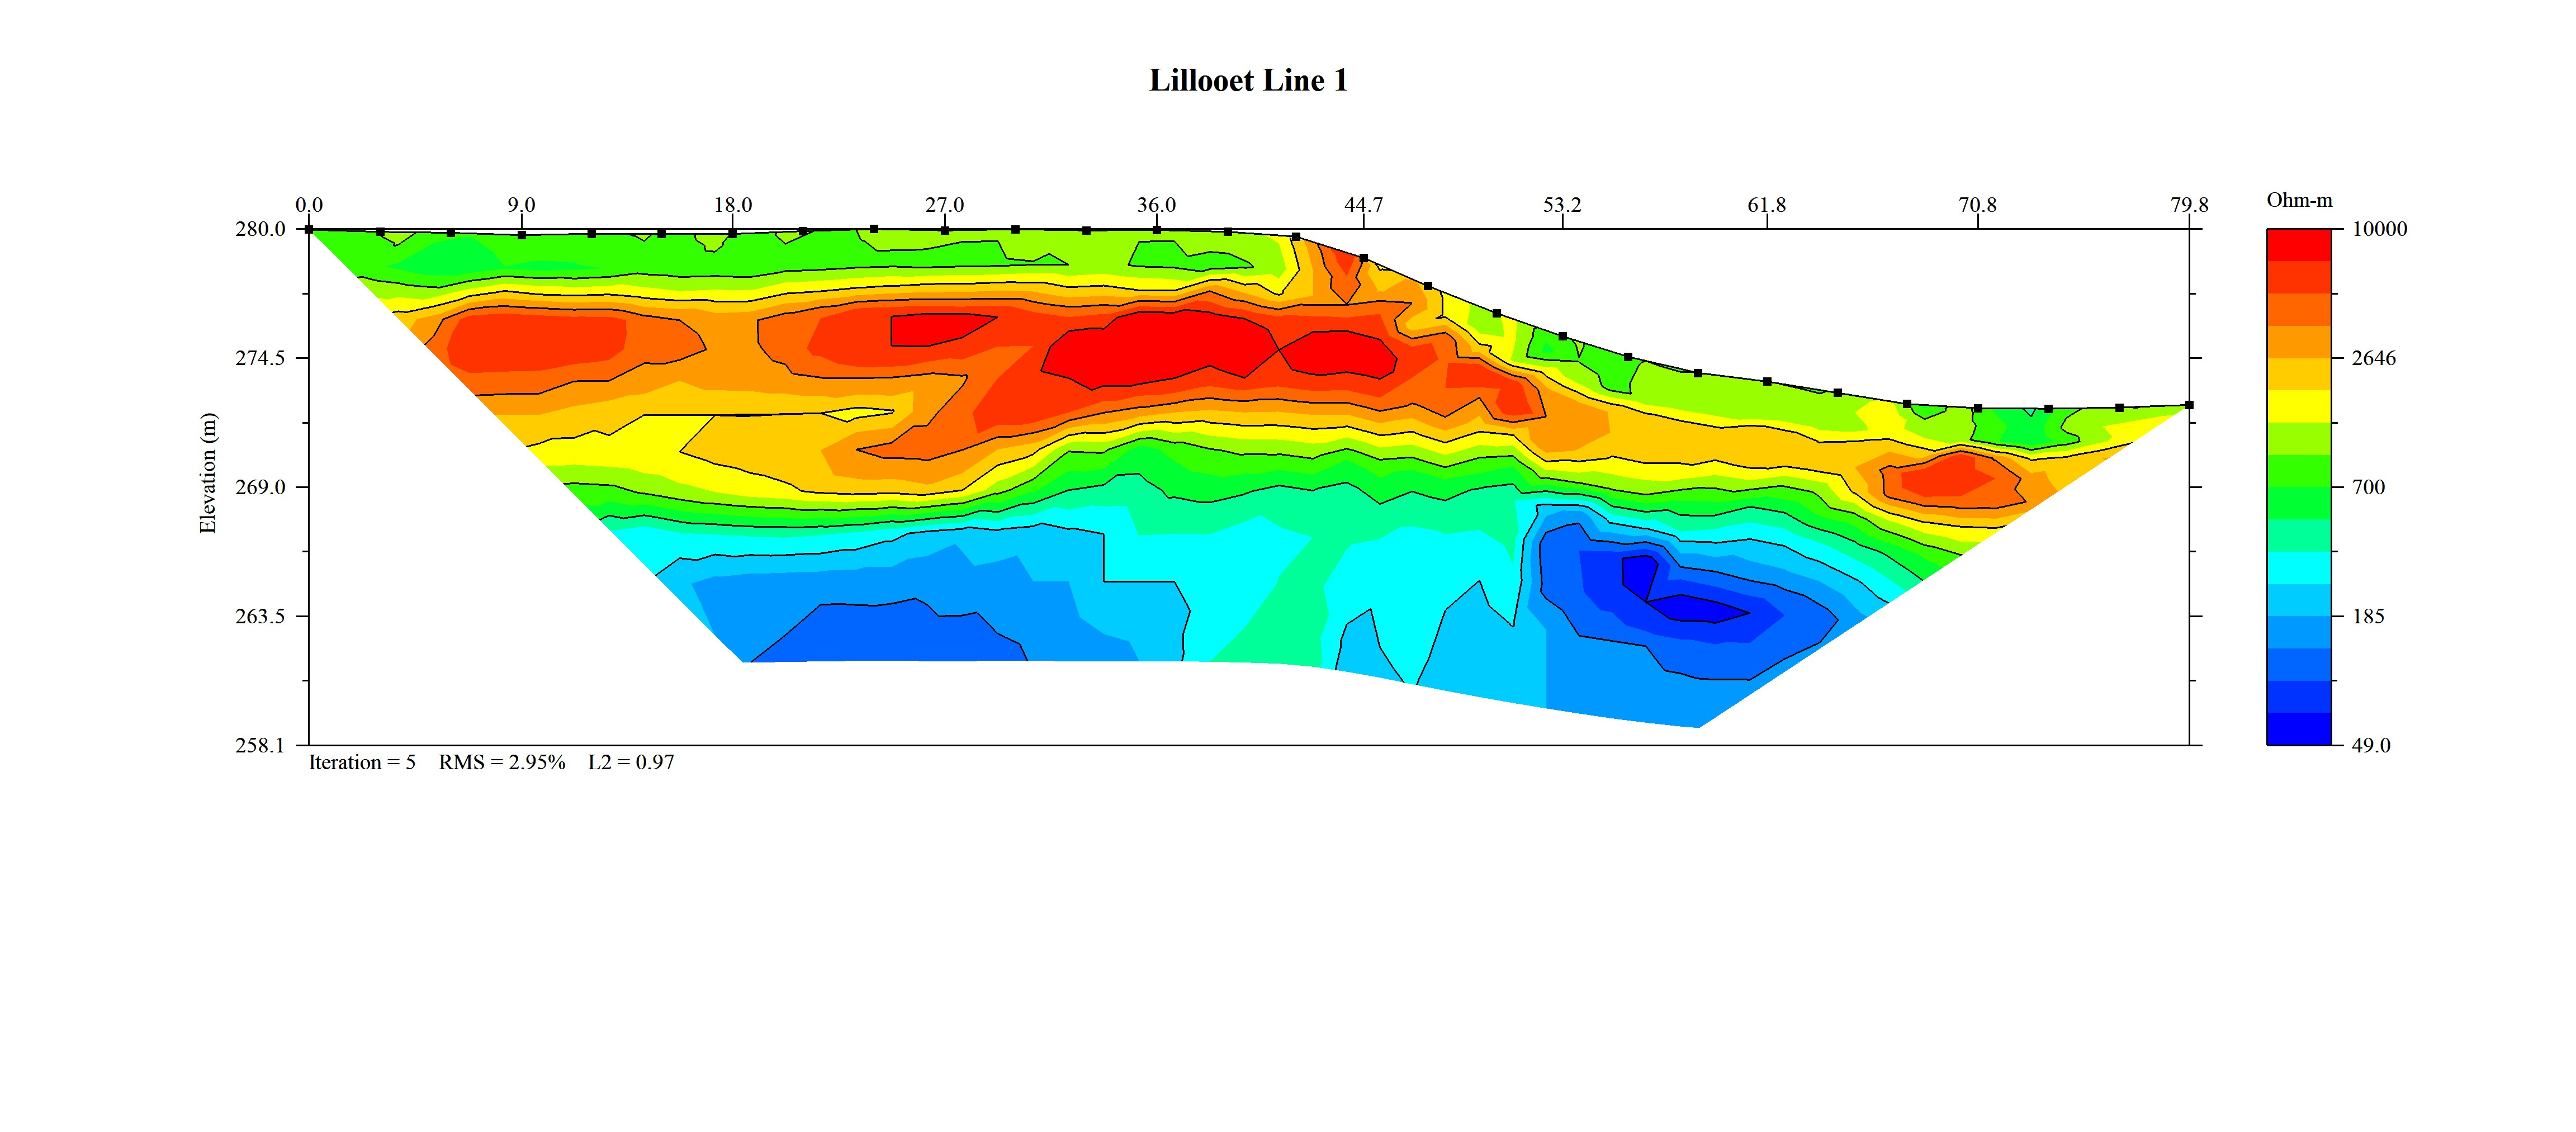

Noisy data points filtered out

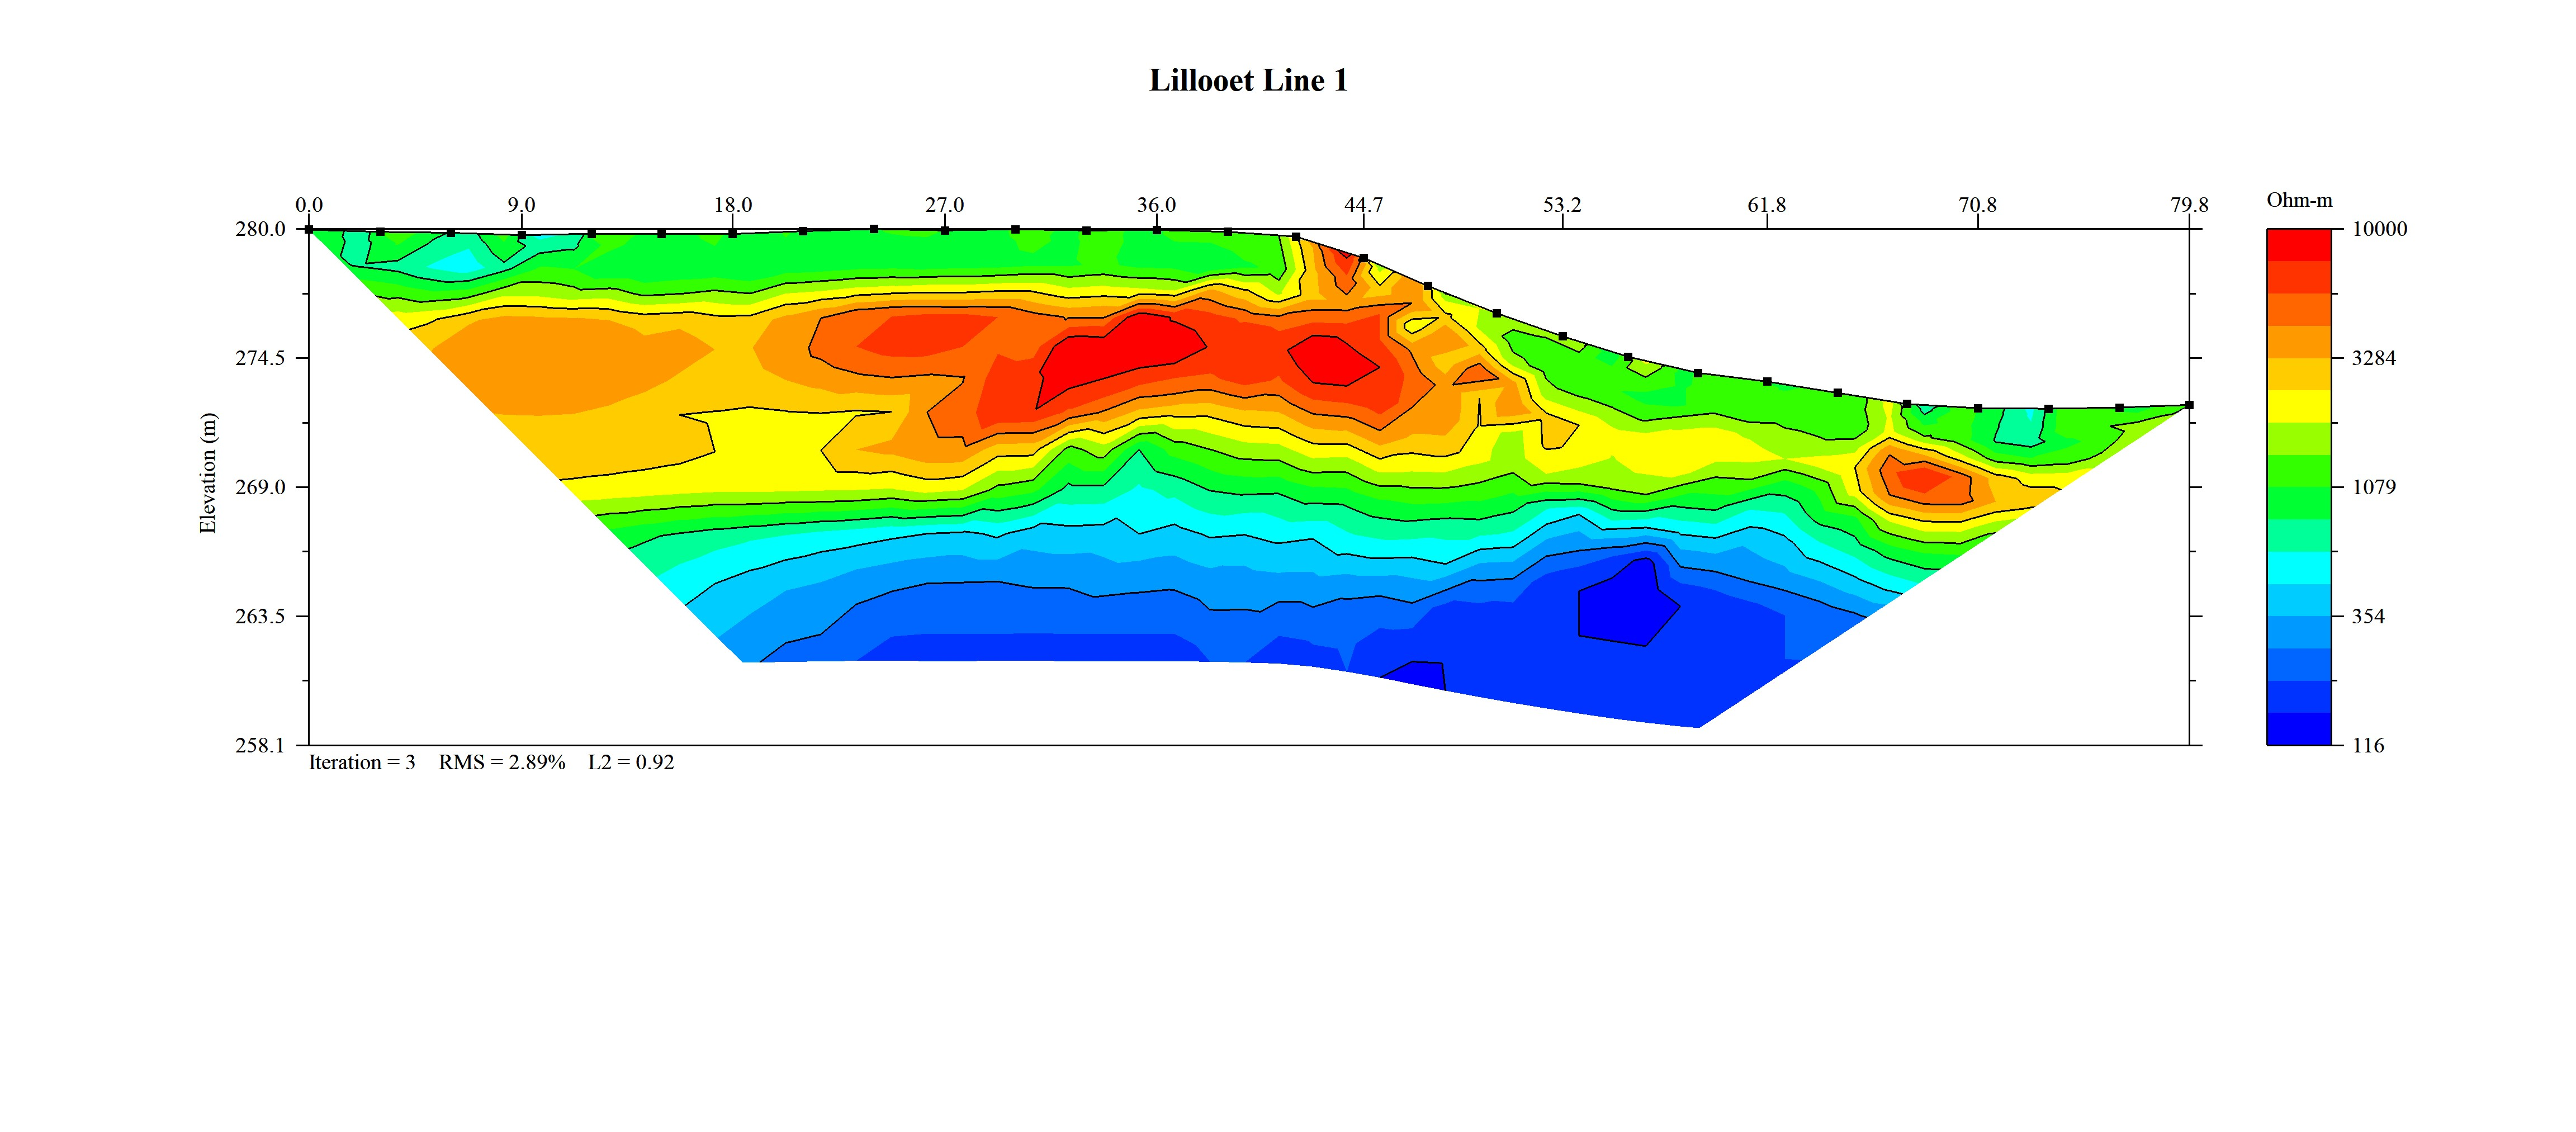

## Calculate RMS error
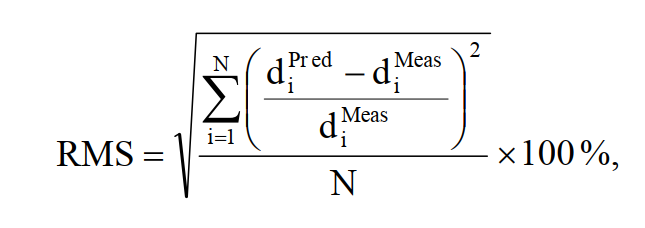

## L2-Norm and Normalized L2-Norm
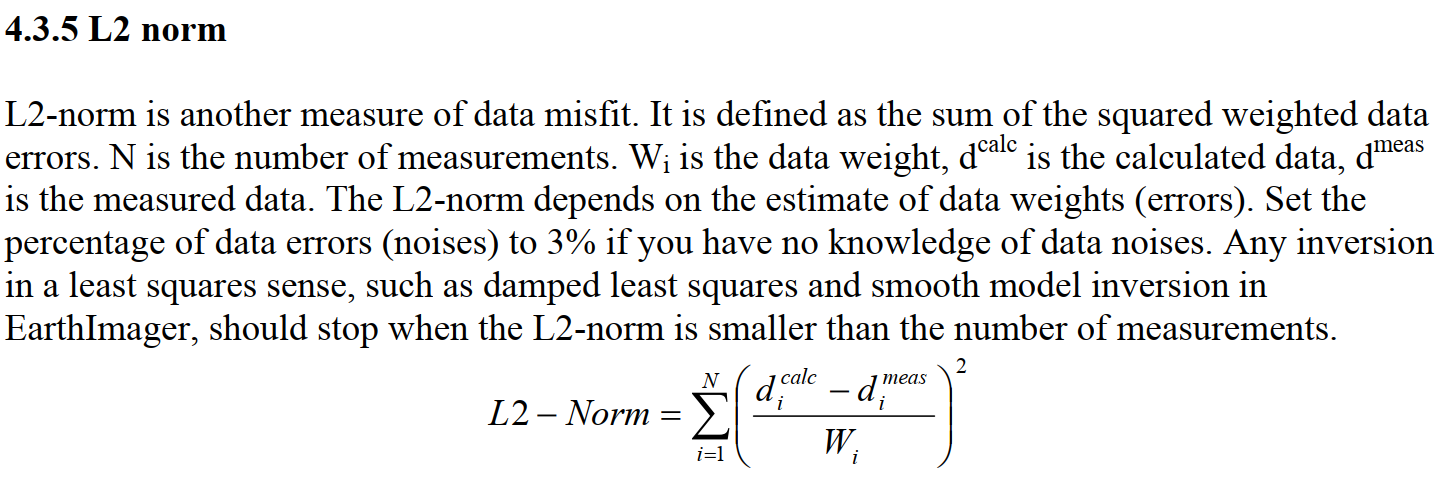
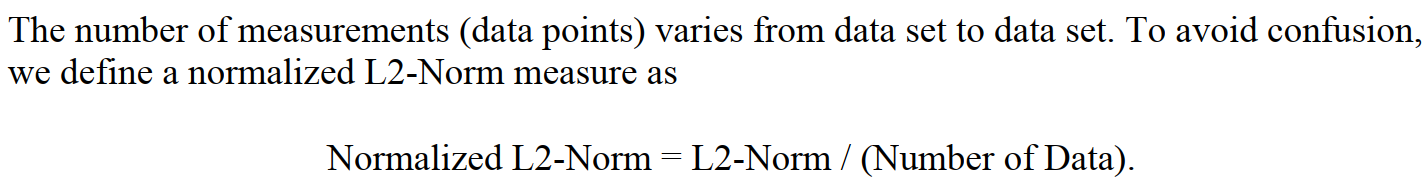

## Results 8: Using log resistivity, unfaulted vs. faulted
Unfaulted

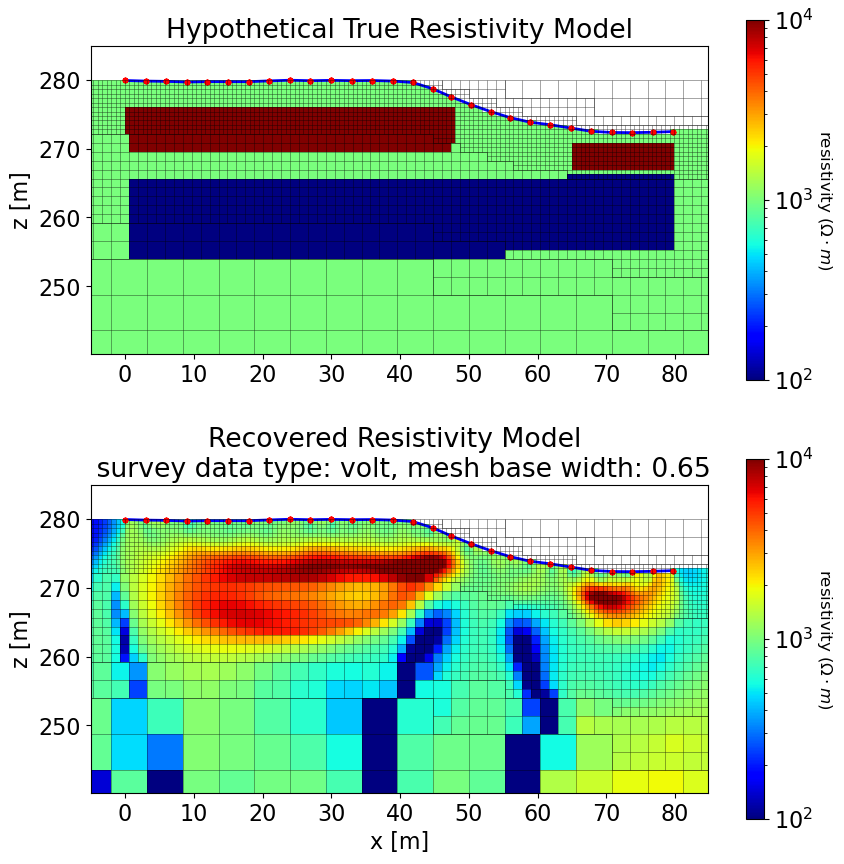

Faulted

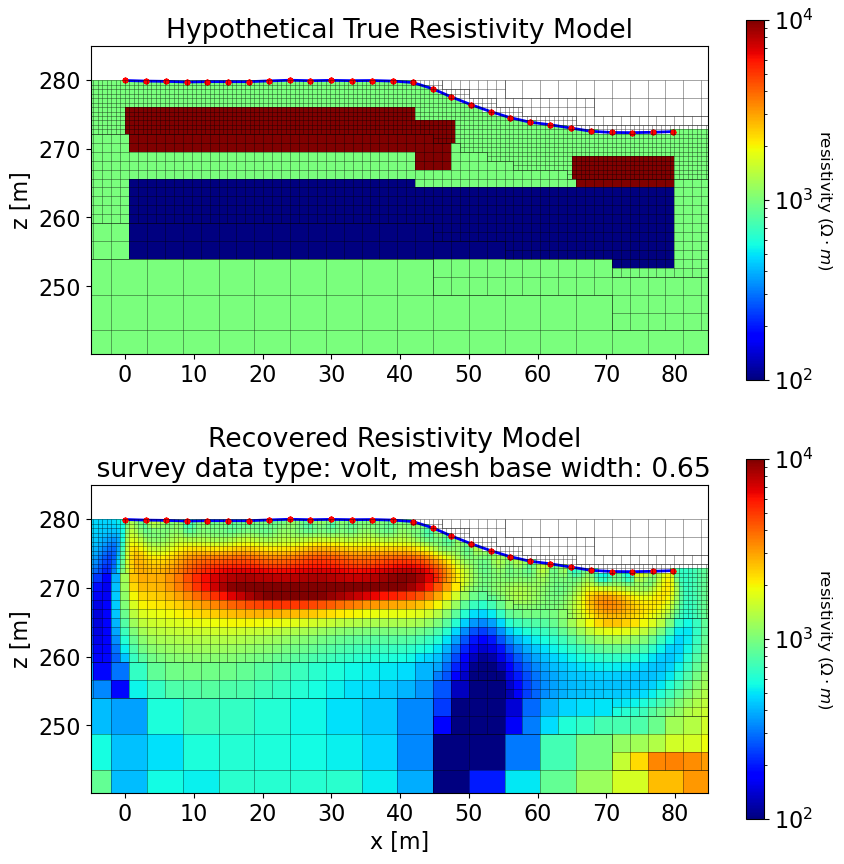

In [ ]:
dpred_recovered = simulation_res.dpred(recovered_resistivity_model)
apparent_resistivities_recovered = apparent_resistivity_from_voltage(survey, dpred_recovered)

In [ ]:
fig4, ax4 = plt.subplots(2,1, figsize=(8,8))

# TOP PLOT
plot_pseudosection(
    data=survey,
    dobs= dpred_recovered-dpred_res,#dpred_res,
    plot_type="scatter",
    ax=ax4[0],
    scale="log",
    cbar_label="Resistance [V/A]",
    scatter_opts={"cmap": colormap_name}
)

# Overlay topography, electrodes, and pseudo-locations
ax4[0].grid()
# Plot topography z-column vs x-column
ax4[0].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax4[0].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax4[0].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax4[0].set_aspect('equal', adjustable='box')

# Configure x- and y-axes
ax4[0].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax4[0].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax4[0].set_xlabel("")
ax4[0].set_ylabel("Pseudo-elevation [m]")
ax4[0].set_title("Normalized Voltages")

# BOTTOM PLOT
plot_pseudosection(
    survey,
    dobs= apparent_resistivities_recovered-apparent_resistivities,
    plot_type="contourf",
    ax=ax4[1],
    scale="log",
    cbar_label=r"$\Omega \cdot m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": colormap_name},
)
ax4[1].set_title("Apparent Resistivity")
# Overlay topography, electrodes, and pseudo-locations
ax4[1].grid()
# Plot topography z-column vs x-column
ax4[1].plot(topography_2d.iloc[:,0], topography_2d.iloc[:,1], color="b", linewidth=2, label='surface', zorder=1)
# Plot electrodes B and N. They are the outer electrodes, so we plot them to show the full range of electrodes.
ax4[1].scatter(locations_b[:,0], locations_b[:,1], 8, "r", label='electrodes')
ax4[1].scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# Set vertical exaggeration to 1
ax4[1].set_aspect('equal', adjustable='box')
# Plot pseudo-locations
ax4[1].scatter(survey_pseudo_locations[:, 0], survey_pseudo_locations[:, -1], marker=".", s=4, color='grey', label='pseudo-locations')

# Configure x- and y-axes
ax4[1].set_xlim(xlim_min-buffer_in_meters, xlim_max+buffer_in_meters)
ax4[1].set_ylim(ylim_min-buffer_in_meters, ylim_max+buffer_in_meters)
ax4[1].set_xlabel("x [m]")
ax4[1].set_ylabel("Pseudo-elevation [m]")

fig4.tight_layout()

## Results 7: Starting model: sand, reference model: sand, data inverted: simulations
Survey object data_type = volts

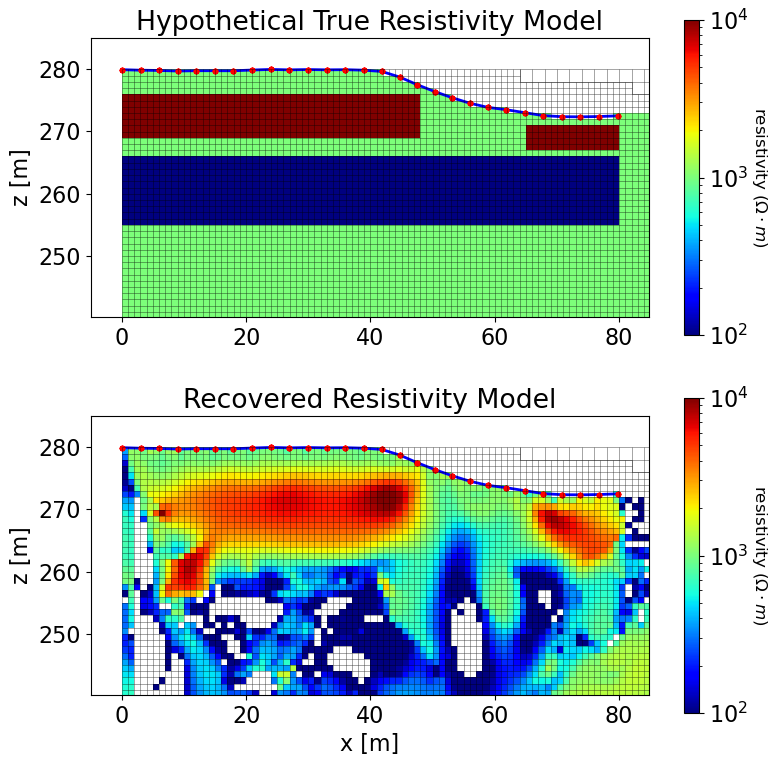

## Results 6: Starting model: sand; reference model: sand; data inverted: field normalized voltages
But this time I specified in the Survey object that dobs is field normalized voltage.
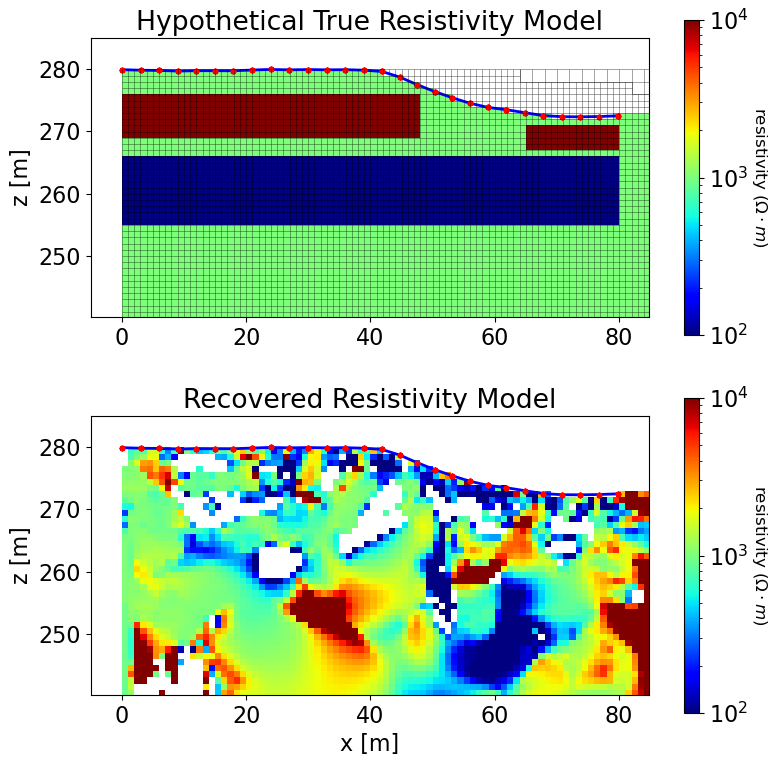

## Results 5: Starting model: sand, reference model: sand, data inverted: field normalized voltages
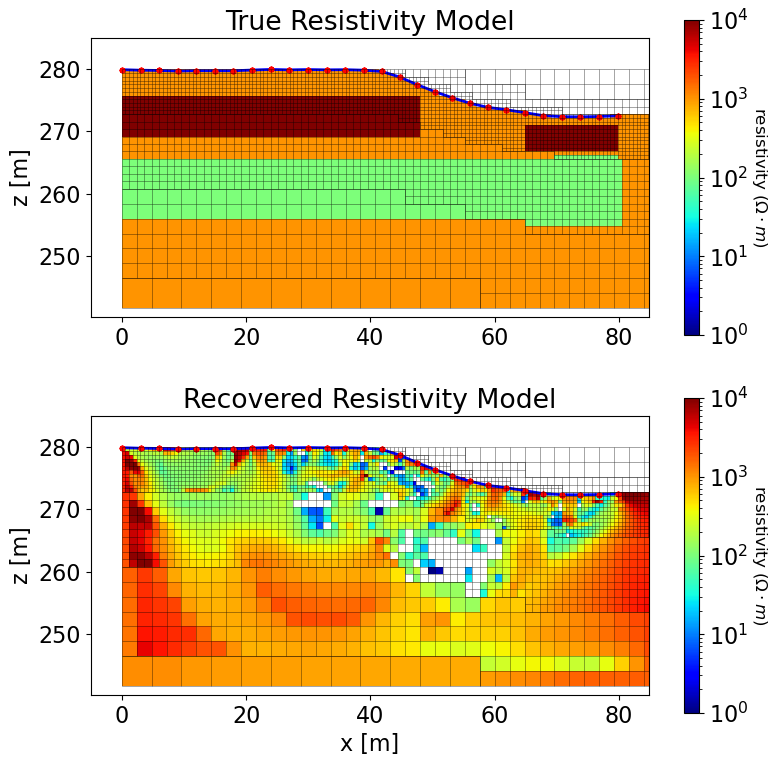

## Results 4: Starting model: sand, reference model: sand, data inverted: field apparent resistivities
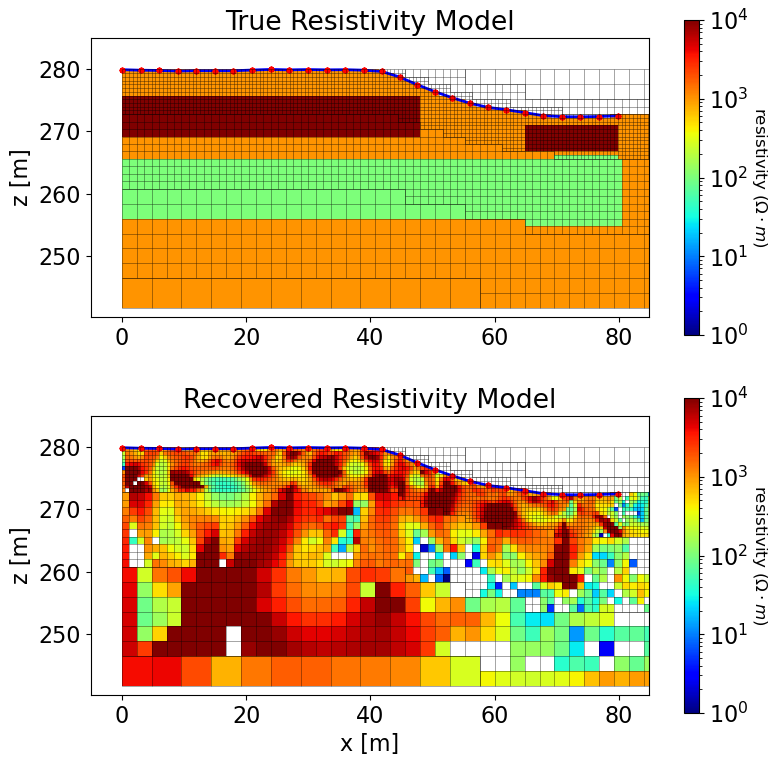

## Results 1: Starting model: sand, reference model: hypothetical true model, data inverted: simulated from hypo. true model
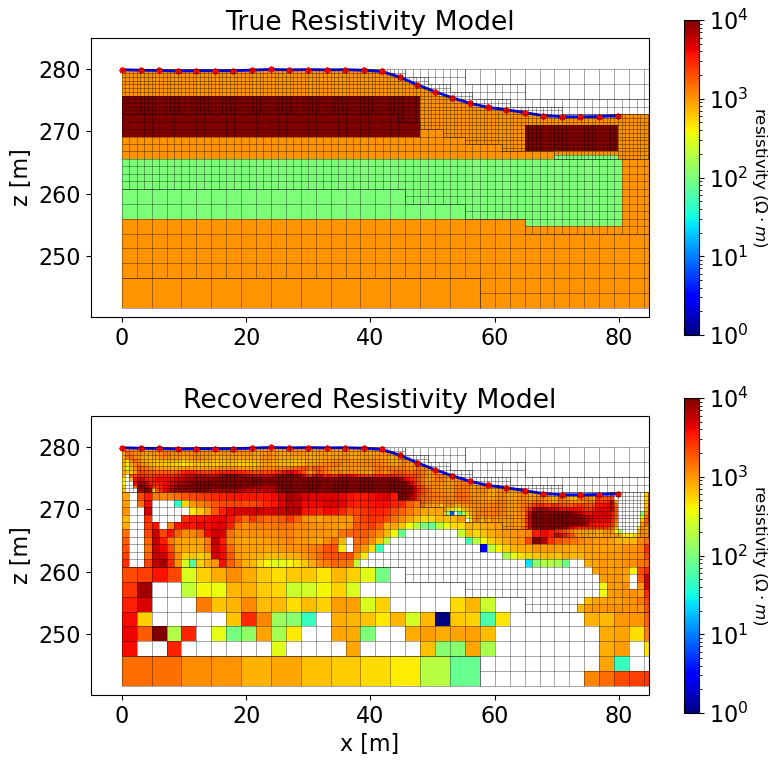

## Results 2: Starting model: sand, reference model = hypothetical true model, data inverted = field data
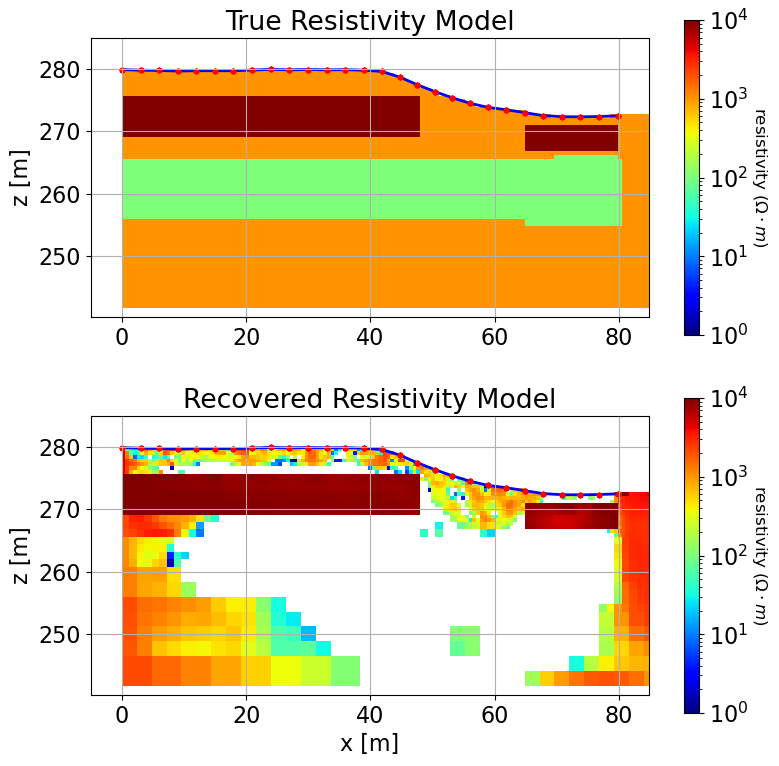

## Results 3: Starting model: all sand, reference model: all sand, inverted data: field data
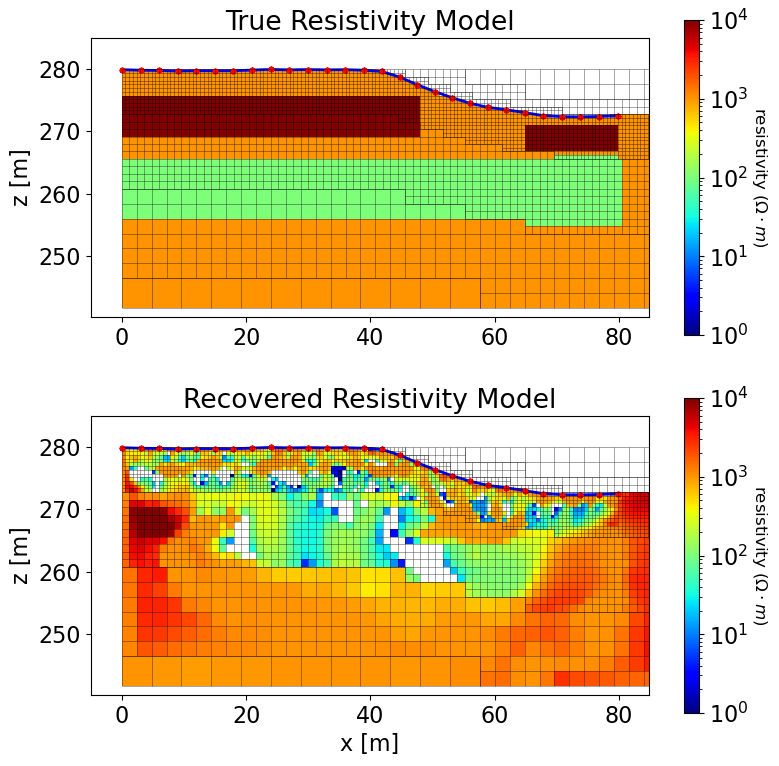